# Model Training on processed Amsterdam data.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

### Load data

In [42]:
path='C:/Zcommon/trainee/project_1/mlpreprocessed.csv'
df=pd.read_csv(path)


## Split into Features and target.

In [43]:
X=df.drop(columns=['price','id','name'])
y=np.log1p(df['price'])

## Taking log1p for price as it has many huge outliers which skew the data big time, and so inorder to have unbiased modeling we have to shrink price a bit, after the calculations it will be returned to normal and actual values will be displayed in accordance with the currency.

# Split

In [44]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# @Random Forest Regression

In [45]:
rf=RandomForestRegressor(n_estimators=600,max_depth=20,random_state=42)


In [46]:
rf.fit(X_train,y_train)

,n_estimators,600
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Predict

In [47]:
rf_pred=rf.predict(X_test)

## Evaluation

In [48]:
mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = root_mean_squared_error(y_test, rf_pred)

print("MAE:", mae_rf)
print("RMSE:", rmse_rf)

MAE: 0.17159429798452822
RMSE: 0.2711006618499612


## Converting to real currecy and evaluating

In [49]:
# convert both predictions and true values back to actual price
predsrf = np.expm1(rf_pred)       # model output → real price
true_y = np.expm1(y_test)         # original y → real price

# compute real-space metrics
mae_real = mean_absolute_error(true_y, predsrf)
rmse_real = root_mean_squared_error(true_y, predsrf)

print(f"Real-Euro MAE (€): {mae_real:.2f}")
print(f"Real-Euro RMSE (€): {rmse_real:.2f}")

Real-Euro MAE (€): 117.44
Real-Euro RMSE (€): 2298.64


In [50]:
true_prices = np.expm1(y_test)

comparison = pd.DataFrame({
    "Actual_Price": true_prices,
    "Predicted_Price": predsrf
})
comparison.head(20)

,Actual_Price,Predicted_Price
1374,86.0,124.841448
808,288.0,245.154634
4842,407.0,323.289021
23,948.0,931.981752
755,125.0,178.385629
3326,271.0,248.572604
3815,92.0,94.964417
3090,178.0,197.062506
5039,405.0,349.183053
3795,80018.0,1470.686973


# XGB Regression

In [51]:
xgb=XGBRegressor()

In [52]:
xgb.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Predict

In [53]:
xgb_pred=xgb.predict(X_test)

## Evaluation

In [54]:
mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = root_mean_squared_error(y_test, xgb_pred)

print("MAE:", mae_xgb)
print("RMSE:", rmse_xgb)

MAE: 0.1364164202942067
RMSE: 0.20792868077485754


## Converting to real currecy and evaluating

In [55]:
# convert both predictions and true values back to actual price
predsxgb = np.expm1(xgb_pred)     # model output → real price
true_y = np.expm1(y_test)         # original y → real price

# compute real-space metrics
mae_real = mean_absolute_error(true_y, predsxgb)
rmse_real = root_mean_squared_error(true_y, predsxgb)

print(f"Real-Euro MAE (€): {mae_real:.2f}")
print(f"Real-Euro RMSE (€): {rmse_real:.2f}")

Real-Euro MAE (€): 98.17
Real-Euro RMSE (€): 1974.68


### An rmse value this huge in real currency is common here as there are some very expensive lsitings that are influencing this factor but there is no problem in predicting other listings. The same goes for other models as well.

In [56]:
true_prices = np.expm1(y_test)

comparison = pd.DataFrame({
    "Actual_Price": true_prices,
    "Predicted_Price": predsxgb
})
comparison.head(20)

,Actual_Price,Predicted_Price
1374,86.0,101.374077
808,288.0,281.249451
4842,407.0,389.387268
23,948.0,689.592224
755,125.0,144.945938
3326,271.0,286.148743
3815,92.0,99.932686
3090,178.0,174.844482
5039,405.0,373.031219
3795,80018.0,12542.301758


# @LGBM Regression

In [75]:
lgb=LGBMRegressor(objective="regression",
    boosting_type="gbdt",
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=64,
    min_data_in_leaf=25,
    lambda_l1=1.2,
    lambda_l2=2.5,
    subsample=0.85,
    colsample_bytree=0.8,
    feature_fraction=0.8,
    bagging_fraction=0.85,
    bagging_freq=3)

In [76]:
lgb.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fracti

,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.03
,n_estimators,1200
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Predict

In [77]:
lgb_pred=lgb.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


## Evaluation

In [78]:
mae_lgb = mean_absolute_error(y_test, lgb_pred)
rmse_lgb = root_mean_squared_error(y_test, lgb_pred)

print("MAE:", mae_lgb)
print("RMSE:", rmse_lgb)

MAE: 0.11961741593023871
RMSE: 0.2074283108678322


In [79]:
# convert both predictions and true values back to actual price
predslgb = np.expm1(lgb_pred)     # model output → real price
true_y = np.expm1(y_test)         # original y → real price

# compute real-space metrics
mae_real = mean_absolute_error(true_y, predslgb)
rmse_real = root_mean_squared_error(true_y, predslgb)

print(f"Real-Euro MAE (€): {mae_real:.2f}")
print(f"Real-Euro RMSE (€): {rmse_real:.2f}")

Real-Euro MAE (€): 100.66
Real-Euro RMSE (€): 2228.46


## Converting to real currecy and evaluating

In [62]:
true_prices = np.expm1(y_test)

comparison = pd.DataFrame({
    "Actual_Price": true_prices,
    "Predicted_Price": predslgb
})
comparison.head(20)

,Actual_Price,Predicted_Price
1374,86.0,93.108002
808,288.0,246.286775
4842,407.0,377.857679
23,948.0,915.006850
755,125.0,146.135774
3326,271.0,267.574221
3815,92.0,76.478004
3090,178.0,183.430429
5039,405.0,372.843141
3795,80018.0,3844.891196


# @CatBoost Regression

In [63]:
cat=CatBoostRegressor()

In [64]:
cat.fit(X_train,y_train)

Learning rate set to 0.052249
0:	learn: 0.5571463	total: 4.54ms	remaining: 4.53s
1:	learn: 0.5468523	total: 8.27ms	remaining: 4.13s
2:	learn: 0.5364422	total: 11.3ms	remaining: 3.77s
3:	learn: 0.5270879	total: 14.3ms	remaining: 3.57s
4:	learn: 0.5179938	total: 17.5ms	remaining: 3.49s
5:	learn: 0.5100921	total: 21ms	remaining: 3.48s
6:	learn: 0.5016050	total: 24.5ms	remaining: 3.47s
7:	learn: 0.4943265	total: 27.3ms	remaining: 3.38s
8:	learn: 0.4875779	total: 30.6ms	remaining: 3.37s
9:	learn: 0.4803449	total: 34.3ms	remaining: 3.39s
10:	learn: 0.4732766	total: 37.3ms	remaining: 3.35s
11:	learn: 0.4677382	total: 40.5ms	remaining: 3.33s
12:	learn: 0.4620577	total: 43.5ms	remaining: 3.3s
13:	learn: 0.4570297	total: 46.4ms	remaining: 3.27s
14:	learn: 0.4517605	total: 49.7ms	remaining: 3.26s
15:	learn: 0.4458198	total: 52.5ms	remaining: 3.23s
16:	learn: 0.4398008	total: 55.6ms	remaining: 3.21s
17:	learn: 0.4347599	total: 58.6ms	remaining: 3.19s
18:	learn: 0.4296161	total: 61.5ms	remaining: 3

## Predict

In [65]:
cat_pred=cat.predict(X_test)

## Evaluation

In [66]:
mae_cat = mean_absolute_error(y_test, cat_pred)
rmse_cat = root_mean_squared_error(y_test, cat_pred)

print("MAE:", mae_cat)
print("RMSE:", rmse_cat)

MAE: 0.10671737931335867
RMSE: 0.1850751607043197


In [67]:
# convert both predictions and true values back to actual price
predscat = np.expm1(cat_pred)     # model output → real price
true_y = np.expm1(y_test)         # original y → real price

# compute real-space metrics
mae_real = mean_absolute_error(true_y, predscat)
rmse_real = root_mean_squared_error(true_y, predscat)

print(f"Real-Euro MAE (€): {mae_real:.2f}")
print(f"Real-Euro RMSE (€): {rmse_real:.2f}")

Real-Euro MAE (€): 94.77
Real-Euro RMSE (€): 2162.11


## Converting to real currecy and evaluating

In [68]:
true_prices = np.expm1(y_test)

comparison = pd.DataFrame({
    "Actual_Price": true_prices,
    "Predicted_Price": predscat
})
comparison.head(20)

,Actual_Price,Predicted_Price
1374,86.0,91.169010
808,288.0,303.902318
4842,407.0,387.787632
23,948.0,802.127264
755,125.0,146.643769
3326,271.0,270.096666
3815,92.0,81.600313
3090,178.0,185.122189
5039,405.0,388.798262
3795,80018.0,6109.542401


# Taking the best scores of all models(by best means with or without internal tuning regression parameters, whichever brings more favourable results).


📊 MODEL PERFORMANCE RANKING:
          Model       MAE      RMSE  Rank
0      CatBoost  0.106717  0.185075   1.0
1      LightGBM  0.119617  0.207428   2.0
2       XGBoost  0.136416  0.207929   3.0
3  RandomForest  0.171594  0.271101   4.0


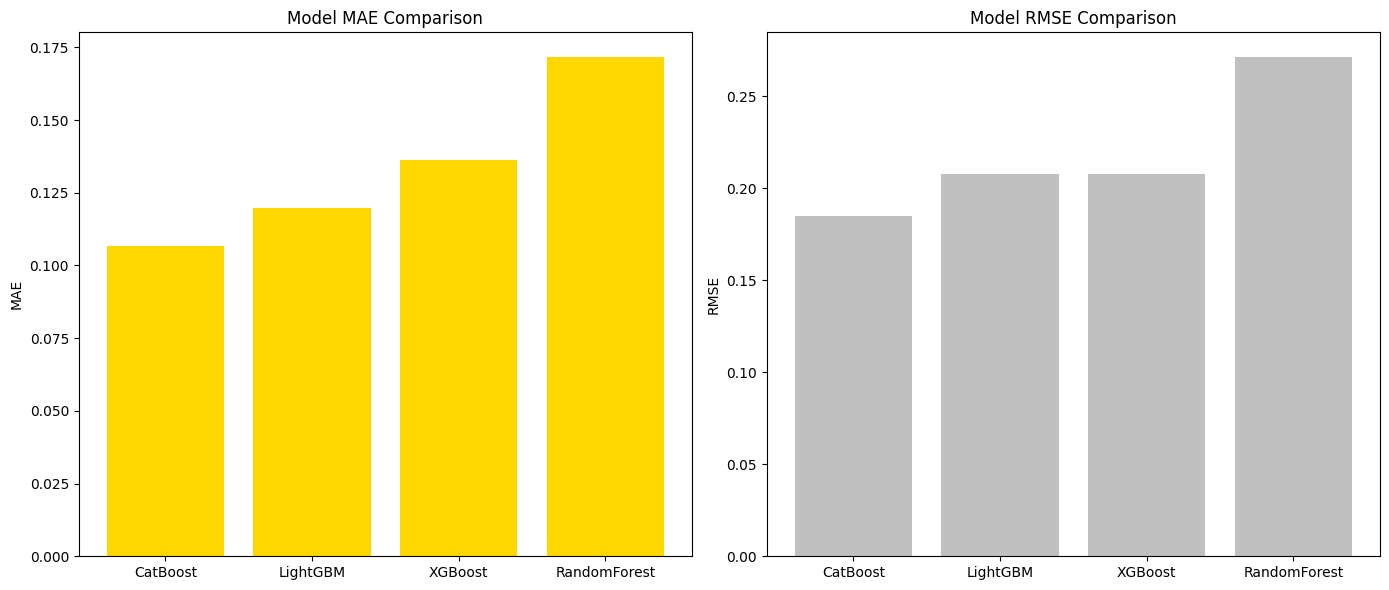

In [69]:
mae_scores = {
    "XGBoost": mae_xgb,
    "RandomForest": mae_rf,
    "LightGBM": mae_lgb,
    "CatBoost": mae_cat
}
rmse_scores = {
    "XGBoost": rmse_xgb,
    "RandomForest": rmse_rf,
    "LightGBM": rmse_lgb,
    "CatBoost": rmse_cat
}
# BUILD PERFORMANCE TABLE
ranking_df = pd.DataFrame({
    "Model": list(mae_scores.keys()),
    "MAE": list(mae_scores.values()),
    "RMSE": list(rmse_scores.values())
})

# COMBINED RANK (true 1,2,3,4 ranking)
ranking_df["Rank"] = ranking_df[["MAE", "RMSE"]].mean(axis=1).rank(method="dense")

# Sort by rank
ranking_df = ranking_df.sort_values("Rank").reset_index(drop=True)

print("\n📊 MODEL PERFORMANCE RANKING:")
print(ranking_df)

# PLOTTING
plt.figure(figsize=(14,6))

# MAE plot
plt.subplot(1,2,1)
plt.bar(ranking_df["Model"], ranking_df["MAE"], color='gold')
plt.title("Model MAE Comparison")
plt.ylabel("MAE")

# RMSE plot
plt.subplot(1,2,2)
plt.bar(ranking_df["Model"], ranking_df["RMSE"], color='silver')
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()


# CatBoost achieved the best predictive performance with the lowest MAE (0.1067) and RMSE (0.1850) on log-transformed price values.
# LightGBM and XGBoost performed similarly but slightly worse.
# RandomForest showed the weakest performance, indicating tree ensembles without boosting are less suited for this dataset.

# END

### Extended code for visualization using maps--part->please ignore.

In [30]:
import joblib
final_model=cat
joblib.dump(final_model,'final_price_model.pkl')
feature_list=list(X_train.columns)
joblib.dump(feature_list,'model_features.pkl')

['model_features.pkl']

In [37]:
path2='C:/Zcommon/trainee/project_1/dataset_part2_amster.csv'
sdf1=pd.read_csv(path2)

In [39]:
all_preds_log=cat.predict(X)
all_preds=np.expm1(all_preds_log)
df['predicted_price']=all_preds
neighbourhood_cleansed=sdf1['neighbourhood_cleansed']
df['neighbourhood_cleansed']=neighbourhood_cleansed

In [40]:
df.to_csv('amster_with_preds.csv',index=False)